# Expected Goals Model

Author: David Shaw

Contact: dsshaw2 [at] ncsu.edu

Date: 11Nov2021

##### Summary

In this notebook, we model the expected number of goals for players using over 435k shots and 38k goals. First, we extract a number of unique features that are not included in other public models. Then, using a custom scoring metric, we trained 8 models in total (4 linear models and 4 tree based models). A random forest tree was selected as our final model. Finally we compare predictions from our model to a leading public model for games in the 2021-22 NHL regular season (up to 08Nov2021), finding very similar error rates. In the wrap up section, we give our thoughts on the future direction of expected goals modeling. Our ultimate conclusion: to improve modeling, focus greater attention on feature extraction.

##### Introduction

My attempt at modeling the expected number of goals for skaters/goalies. In addition to features other models have integrated, such as [change in shot angle](https://www.moneypuck.com/about.htm), this model includes goaltender days of rest, number and direction of timezones traveled through since previous game, and shooter/goalie characteristics (height, weight, handness).  

This notebook contains the following:

* [Downloading Data](#0)
* [Loading Data](#1)
* [Data Mining](#2)
* [Feature engineering](#3)
* [Exploratory Data Analysis](#4)
    * [Shot Timeline and Shot Outcome](#4.1)
    * [Shot Location and Shot Outcome](#4.2)
    * [Change in Shot Angle vs Shot Outcome](#4.3)
    * [Change in Timezone and Effect on Shot Outcome ](#4.4)
    * [Shot Type and Shot Outcome](#4.5)
* [Model Building](#5)
    * [Test-Train-Split](#5.1)
    * [Model Training](#5.2)
    * [Model Testing](#5.3)
* [Final Model and Comparison](#6)
    * [Calculate Error Rate of MoneyPuck Model](#6.1)
    * [Calculate Error Rate of My Model](#6.2)
    * [Go Beyond Error Rate, Dive into Differences Between Models](#6.3)
* [Moving Foward](#7)
    * [Model Selection: Performance vs Interpretability](#7.1)
    * [Model Selection: Scoring Metrics](#7.2)
    * [Model Building: Other Models to Consider](#7.3)



In [1]:
import os
import json
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

### Downloading Data <a class="anchor" id="0"></a>

**_Only do this if you do not have data on local drive. This will download ~3GB of data._**

First, let us load the data from an AWS [S3 bucket](https://s3.console.aws.amazon.com/s3/buckets/nhl-api-game-events?region=us-west-2&tab=objects). Data was originally retrieved from the [NHL Public API](https://gitlab.com/dword4/nhlapi/-/blob/master/stats-api.md).

In [2]:
# import boto3

# # input your credentials, bucket is public but we need a personal AWS account these to gain programatic access
# s3 = boto3.client(
#     's3',
#     aws_access_key_id='xxxx',
#     aws_secret_access_key='xxxxx'
# )

# # download objects to data foler
# BUCKET_NAME = 'nhl-api-game-events'
# seasons = ['2015', '2016', '2017', '2018', '2019', '2020', '2021']
# for season in seasons:
#     OBJECT_NAME = f'{season}_regSeasonPlays.json'
#     FILE_NAME = f'../data/gameData/{season}_regSeasonPlays.json'
#     s3.download_file(BUCKET_NAME, OBJECT_NAME, FILE_NAME)

### Loading Data <a class="anchor" id="1"></a>

Now, we will load all data into memory.

In [3]:
years = ['2015','2016','2017','2018', '2019', '2020', '2021']
games = {}
for year in years:
    path = '../data/gameData/' + year + '_regSeasonPlays.json'
    print(path)
    with open(path) as f:
        games[year] = json.load(f)

../data/gameData/2015_regSeasonPlays.json
../data/gameData/2016_regSeasonPlays.json
../data/gameData/2017_regSeasonPlays.json
../data/gameData/2018_regSeasonPlays.json
../data/gameData/2019_regSeasonPlays.json
../data/gameData/2020_regSeasonPlays.json
../data/gameData/2021_regSeasonPlays.json


### Data mining <a class="anchor" id="2"></a>

Here, we'll parse the raw json data structures for the information we care about, shots! 

In [4]:
# get information we care about: shots and goals
shots = []
for season in games:
    for game_id in games[season]:
        home_team = games[season][game_id]['home_team']
        away_team = games[season][game_id]['away_team']
        for event in games[season][game_id]['events']:
            # if event is shot or goal, save it
            if event['result']['event'] == 'Shot' or event['result']['event'] == 'Goal':
                shooter = ''
                shooter_id = 0
                goalie = ''
                goalie_id = 0

                # extract shooter/goalie
                for player in event['players']:
                    if player['playerType'] == 'Shooter' or player['playerType'] == 'Scorer':
                        shooter = player['player']['fullName']
                        shooter_id = player['player']['id']
                    elif player['playerType'] == 'Goalie':
                        goalie = player['player']['fullName']
                        goalie_id = player['player']['id']

                # extract shooter/goalie team
                shooter_team = event['team']['name']
                goalie_team = home_team
                if goalie_team == shooter_team: goalie_team = away_team

                # extract strength for goal
                strength = 'unknown'
                try:
                    strength = event['result']['strength']['name']
                except:
                    pass

                shots.append({
                    'season_id': season,
                    'game_id': game_id,
                    'home_team': home_team,
                    'away_team': away_team,
                    'dateTime': event['about']['dateTime'],
                    'period': event['about']['period'],
                    'periodTime': event['about']['periodTime'],
                    'x_loc': event['coordinates'].get('x', np.NaN),
                    'y_loc': event['coordinates'].get('y', np.NaN),
                    'shooter': shooter,
                    'shooter_id': shooter_id,
                    'shooter_team': shooter_team,
                    'goalie': goalie,
                    'goalie_id': goalie_id,
                    'goalie_team': goalie_team,
                    'is_goal': (event['result']['event'] == 'Goal'),
                    'shot_type': event['result'].get('secondaryType'),                
                    'strength': strength
                })

### Feature engineering <a class="anchor" id="3"></a>
The following features are extracted from the raw data and used as predictors in our models. Additional data, such as shooter/goalie characteristics and travel between timezones are extracted.

* time since last shot (time in period) **records of actual time are inaccurate
* coordinates location of shoot
* change of angle since last shot
* change in distance since last shot
* days rest for goaltender
* characteristics of shooter/goalie
    * handness
    * height
    * weight
    * age
* amount of travel since previous game

In [5]:
# convert to dataframe
df = pd.DataFrame(shots)
df = df[df['goalie'] != ''] # filter empty net goals
df = df[df['period'] != 5] # filter shootout attempts


# find total seconds between shots (periodTime)
df['time_seconds'] = df['periodTime'].str[:2].astype(int) * 60 + df['periodTime'].str[3:].astype(int)
df['time_seconds'] = np.where(df['period'] == 2, df['time_seconds'] + 1200, 
                                 np.where(df['period'] == 3, df['time_seconds'] + 2400, df['time_seconds']))
df = df.sort_values(by=['game_id', 'goalie', 'time_seconds']) # sort by game_id and goalie name
df['time_seconds_diff'] = df.groupby(['game_id', 'goalie'])['time_seconds'].diff(1).fillna(df['time_seconds'])

# get total shots
df['tot_shots'] = 1
df['tot_shots'] = df.groupby(['game_id', 'goalie'])['tot_shots'].cumsum()

# fix all shots to one side of ice (adjust x and y coordinates)
df.loc[df['x_loc'] < 0, 'y_loc'] = df['y_loc'] * -1
df['x_loc'] = df['x_loc'].abs()
df = df[df['x_loc'].notna()]

# calculate angle of shot compared to goal
x_goal = 89
df['shot_angle'] = np.where(df['x_loc'] != x_goal,
                            # when shot is from behind the net
                            np.where(df['x_loc'] > x_goal,
                                     np.where(df['y_loc'] >= 0,
                                              round(90 + (90 - np.arctan(df['y_loc'] / (df['x_loc'] - x_goal)) * (180 / np.pi)), 2),
                                              round(-90 - (90 + np.arctan(df['y_loc'] / (df['x_loc'] - x_goal)) * (180 / np.pi)), 2)
                                             ),
                                     # when shot is in front of net
                                     round(np.arctan(df['y_loc'] / (x_goal - df['x_loc'])) * (180 / np.pi), 2)
                                    ),
                            # when shot is taken on the goal line
                            np.where(df['y_loc'] >= 0, 90, -90)
                           )

# calculate difference in shot angle
df['shot_angle_prev'] = df.groupby(['game_id', 'goalie'])['shot_angle'].shift(1).fillna(0)
df['shot_angle_diff'] = np.absolute(np.where(df['shot_angle'] < df['shot_angle_prev'],
                                                df['shot_angle'] - df['shot_angle_prev'],
                                                df['shot_angle_prev'] - df['shot_angle']
                                            )
                                   )

# determine if goalie moved to his right since last shot to attempt to make save
df['goalie_move_right'] = np.where(df['shot_angle'] > df['shot_angle_prev'], True, False)

# calculate shot distance to goal
df['shot_dist'] = round(np.sqrt(np.square(df['x_loc'] - x_goal) + np.square(df['y_loc'])), 2)
df['shot_dist_prev'] = df.groupby(['game_id', 'goalie'])['shot_dist'].shift(1).fillna(0)
df['shot_dist_diff'] = df['shot_dist'] - df['shot_dist_prev']

# get days rest for goalie (if at begining of season, just mark days rest as 5)
df_goalies = df[['game_id', 'goalie', 'dateTime']].groupby(['goalie', 'game_id']).first()
df_goalies['dateTime_prev'] = df_goalies['dateTime'].shift(1).fillna('1970-01-01T04:00:00Z')
df_goalies['goalie_days_rest'] = (pd.to_datetime(df_goalies['dateTime']) - pd.to_datetime(df_goalies['dateTime_prev'])).dt.round(freq='D').dt.days
df_goalies['goalie_days_rest'] = np.where(df_goalies['goalie_days_rest'] > 200, 
                                          5, 
                                          np.where(df_goalies['goalie_days_rest'] < 0,
                                                   5,
                                                   df_goalies['goalie_days_rest']
                                                  )
                                         )
df = df.sort_values(by=['goalie', 'game_id']).merge(df_goalies[['goalie_days_rest']], how='left', on=['goalie', 'game_id'])

# get player characteristics (age, height, weight, handness) and merge with dataframe
## characteristics mined in 'player_miner.ipynb'
with open('../data/playerAttributes.json') as f:
    attributes = json.load(f)          # read file
df_atr = pd.DataFrame(attributes)      # convert to df
df_atr.sort_values('id', inplace=True) # sort by id

# merge skater attrs
df_atr_skaters = df_atr[(df_atr['type']=='Forward') | (df_atr['type']=='Defenseman')]    # filter by skaters
df_atr_skaters.columns = [f'shooter_{c}' for c in list(df_atr.columns)]                  # rename columns
df = df.sort_values('shooter_id').merge(df_atr_skaters, how='left', on='shooter_id')     # merge 
df['shooter_age'] = round((pd.to_datetime(df['dateTime'].str[:10]) - 
                           pd.to_datetime(df['shooter_birthDate'])).dt.days / 365, 1)      # calculate age

# merge goalie attrs
df_atr_goalies = df_atr[df_atr['type']=='Goalie']                                   # filter by goalies
df_atr_goalies.columns = [f'goalie_{c}' for c in list(df_atr.columns)]              # rename columns
df = df.sort_values('goalie_id').merge(df_atr_goalies, how='left', on='goalie_id')  # merge 
df['goalie_age'] = round((pd.to_datetime(df['dateTime'].str[:10]) - 
                          pd.to_datetime(df['goalie_birthDate'])).dt.days / 365, 1) # calculate age

# calculate circadian effects (number of timezones crossed since last game)
with open('../data/teamCircadian.json') as f:
    d = json.load(f)          # read file
df_circ = pd.DataFrame(d)      # convert to df
df_circ = df_circ[['game_id', 'team', 'offset_diff']]

# merge skater circadian
df_circ.columns = ['game_id', 'shooter_team', 'shooter_tzTraveled']
df = df.sort_values(['shooter_team', 'game_id']).merge(df_circ, how='left', on=['shooter_team', 'game_id'])

# merge goalie circadian
df_circ.columns = ['game_id', 'goalie_team', 'goalie_tzTraveled']
df = df.sort_values(['goalie_team', 'game_id']).merge(df_circ, how='left', on=['goalie_team', 'game_id'])

# generate dummy vars
df = pd.get_dummies(df, columns=['shot_type', 'shooter_type', 'shooter_shootsCatches', 'goalie_shootsCatches'])

# drop rows with missing values
df.dropna(axis=0, inplace=True) 

df.head()


,season_id,game_id,home_team,away_team,dateTime,period,periodTime,x_loc,y_loc,shooter,...,shot_type_Snap Shot,shot_type_Tip-In,shot_type_Wrap-around,shot_type_Wrist Shot,shooter_type_Defenseman,shooter_type_Forward,shooter_shootsCatches_L,shooter_shootsCatches_R,goalie_shootsCatches_L,goalie_shootsCatches_R
0,2015,2015020030,San Jose Sharks,Anaheim Ducks,2015-10-11T04:50:04Z,3,07:07,85.0,-5.0,Joe Pavelski,...,0,0,1,0,0,1,0,1,1,0
1,2015,2015020030,San Jose Sharks,Anaheim Ducks,2015-10-11T04:42:41Z,3,02:24,69.0,-3.0,Joe Pavelski,...,0,1,0,0,0,1,0,1,1,0
2,2015,2015020030,San Jose Sharks,Anaheim Ducks,2015-10-11T04:55:57Z,3,11:41,70.0,-9.0,Joonas Donskoi,...,0,0,0,0,0,1,0,1,1,0
3,2015,2015020030,San Jose Sharks,Anaheim Ducks,2015-10-11T04:08:42Z,2,13:48,44.0,-28.0,Brent Burns,...,0,0,0,0,1,0,0,1,1,0
4,2015,2015020030,San Jose Sharks,Anaheim Ducks,2015-10-11T04:44:11Z,3,03:53,49.0,-34.0,Brent Burns,...,0,0,0,0,1,0,0,1,1,0


### Exploratory Data Analysis <a class="anchor" id="4"></a>

##### Shot Timeline and Shot Outcome <a class="anchor" id="4.1"></a>

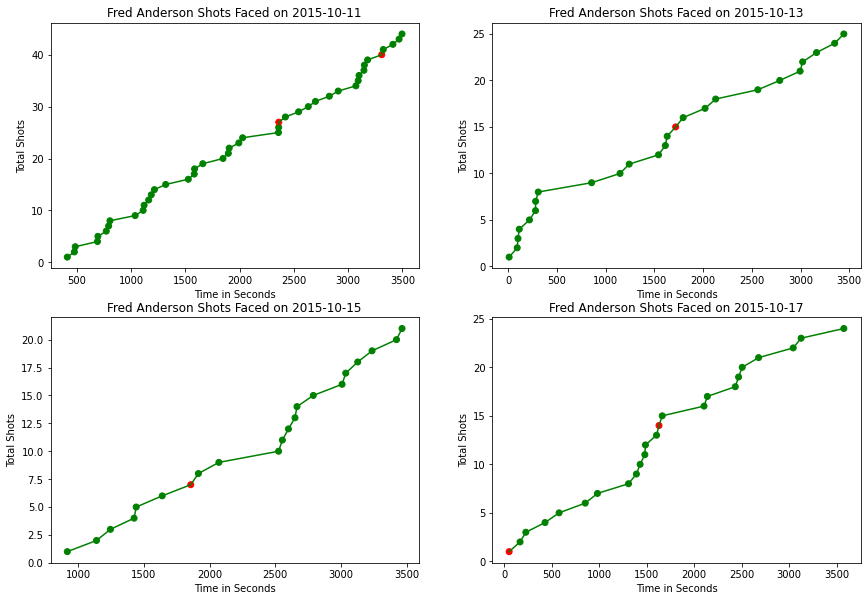

In [6]:
df_tmp = df[df['goalie']=='Frederik Andersen'].sort_values(['game_id', 'time_seconds'])
game_ids = df_tmp['game_id'].unique().tolist()[0:4] # get list of four games

# initiate plots
fig = plt.figure()
subs = [221,222,223,224]

for i in range(0,len(game_ids)):
    df_tmp2 = df_tmp[df_tmp['game_id']==game_ids[i]]
    date = df_tmp2['dateTime'].iloc[0][0:10]
    color = ['red' if goal else 'green' for goal in df_tmp2['is_goal'] ]

    ax=fig.add_subplot(subs[i])
    ax.scatter(df_tmp2['time_seconds'], df_tmp2['tot_shots'], c=color)
    ax.plot(df_tmp2['time_seconds'], df_tmp2['tot_shots'], color='green')
    plt.title(f'Fred Anderson Shots Faced on {date}')
    plt.xlabel("Time in Seconds")
    plt.ylabel("Total Shots")

plt.subplots_adjust(top=2, right=2)
plt.show()

The above grid of charts shows the time differential between shots, along with goals allowed colored in red. It is imagined that when goalies do not see a shot for some time, they become 'cold' which can cause the next shot to have a higher percentage of beating them. Therefore, we will extract the difference in time between shots faced by goalies as a feature of our model.

##### Shot Location and Shot Outcome <a class="anchor" id="4.2"></a>

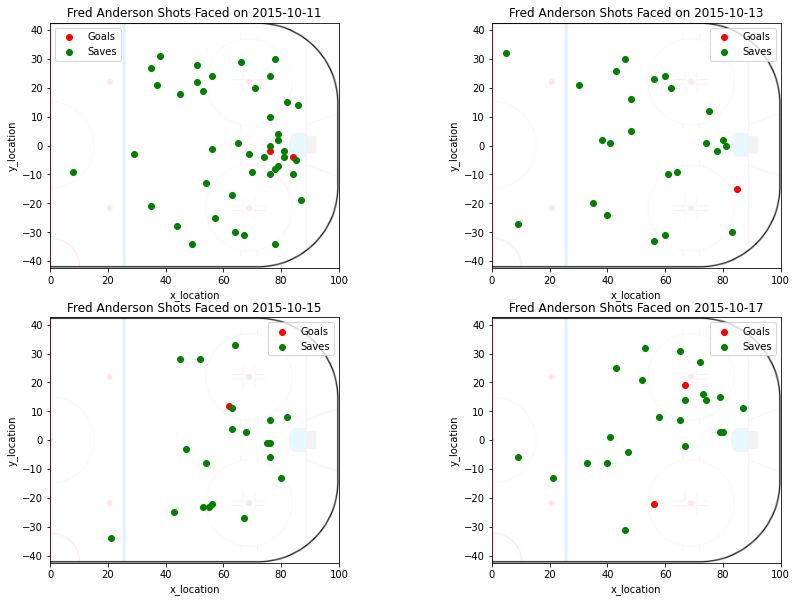

In [7]:
df_tmp = df[df['goalie']=='Frederik Andersen'].sort_values(['game_id', 'time_seconds'])
game_ids = df_tmp['game_id'].unique().tolist()[0:4] # get list of four games

# initiate plots
fig = plt.figure()
subs = [221,222,223,224]

for i in range(0,len(game_ids)):
    df_tmp2 = df_tmp[df_tmp['game_id']==game_ids[i]]
    date = df_tmp2['dateTime'].iloc[0][0:10]

    # read img (retrieved from https://thewincolumn.ca/2021/01/15/r-tutorial-creating-an-nhl-rink-using-the-tidyverse/)
    img = plt.imread("../data/images/nhl_rink_plot_output_light.png")
    ax = fig.add_subplot(subs[i])
    ax.imshow(img, extent=[0, 100, -42.5, 42.5])

    # plot
    goals = ax.scatter(df_tmp2[df_tmp2['is_goal']==True]['x_loc'], 
                        df_tmp2[df_tmp2['is_goal']==True]['y_loc'], 
                        c='red', 
                        label='Goals')
    non_goals = ax.scatter(df_tmp2[df_tmp2['is_goal']==False]['x_loc'], 
                            df_tmp2[df_tmp2['is_goal']==False]['y_loc'], 
                            c='green', 
                            label='Saves')
    plt.title(f'Fred Anderson Shots Faced on {date}')
    plt.xlabel("x_location")
    plt.ylabel("y_location")
    ax.legend()

plt.subplots_adjust(top=2, right=2)
plt.show()

Above we see charts of shot location and outcome of shot. Shot location is likely the most influential feature of an expected goals model. To add additional detail to shot coordiantes, we will create features to represent the distance of a shot to the net and the angle of a shot (compared to the slot).

##### Change in Shot Angle vs Shot Outcome <a class="anchor" id="4.3"></a>

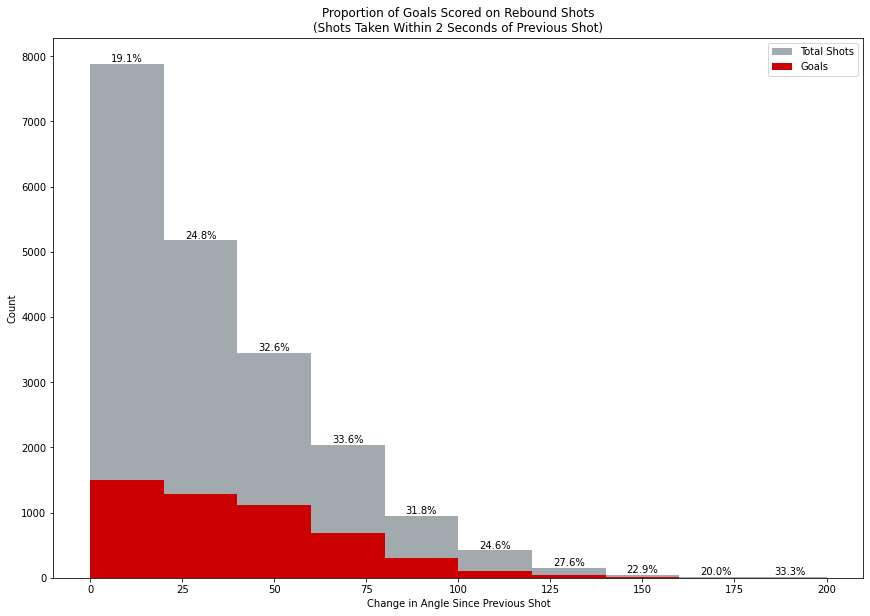

In [8]:
df_rebounds = df[df['time_seconds_diff'] <= 2].copy() # get shots with previous shot taken in past 3 seconds
# df_rebounds = df_rebounds[df_rebounds['goalie'] != ''] # filter empty netters

fig, ax = plt.subplots()

bins = list(np.linspace(0,200,11))
non_goals = plt.hist(df_rebounds['shot_angle_diff'],
                        color='#A2AAAD',
                        label='Total Shots',
                        bins=bins)
goals = plt.hist(df_rebounds[df_rebounds['is_goal'] == True]['shot_angle_diff'],
                color='#CC0000',
                label='Goals',
                bins=bins)

plt.title('Proportion of Goals Scored on Rebound Shots\n(Shots Taken Within 2 Seconds of Previous Shot)')
plt.xlabel("Change in Angle Since Previous Shot")
plt.ylabel("Count")
ax.legend()

# create labels
rects = ax.patches
labels = []
for i in range(len(goals[0])):
    labels.append(round(goals[0][i] / non_goals[0][i] * 100,1))


# apply labels
for rect, label in zip(rects, labels):
    height = rect.get_height()
    text_color = 'black'
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, str(label)+'%',
            ha='center', va='bottom', color=text_color)
    
plt.subplots_adjust(top=2, right=2)
plt.show()

Above we see a histogram of change and shot angle and proportion of succesful shots. We see that as we increase the change in angle, the proportion of succesful shots increases. This will certainly be a feature to include in our model.

##### Change in Timezone and Effect on Shot Outcome <a class="anchor" id="4.4"></a>

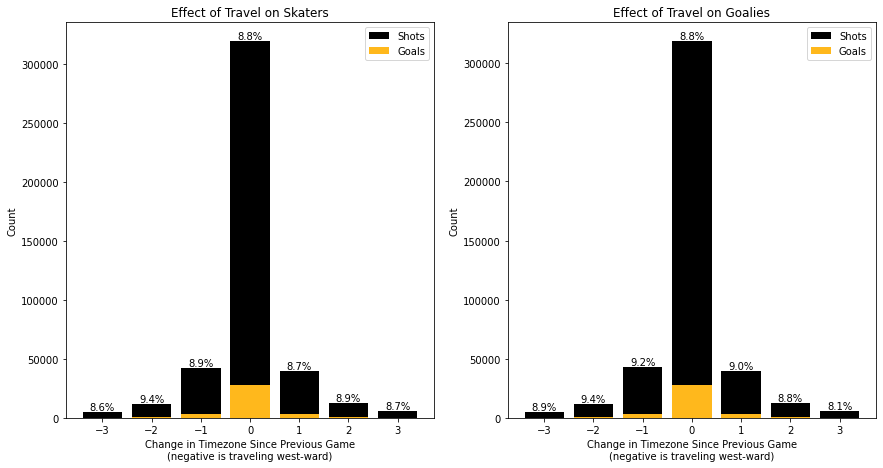

In [9]:
# get timezone differential and number of goals for skaters / number of goals against for goalies 
df_tmp = df[['is_goal', 'shooter_tzTraveled', 'goalie_tzTraveled']].copy() 
df_tmp.groupby('goalie_tzTraveled')['is_goal'].sum()
timezones = sorted(df_tmp['shooter_tzTraveled'].unique())

# extract data as arrays
timezones_skater_shots = df_tmp.groupby('shooter_tzTraveled').size().values
timezones_skater_goals = df_tmp.groupby('shooter_tzTraveled')['is_goal'].sum().values
timezones_goalie_shots = df_tmp.groupby('goalie_tzTraveled').size().values
timezones_goalie_goals = df_tmp.groupby('goalie_tzTraveled')['is_goal'].sum().values

fig = plt.figure()

#### create skater performance plot ###
ax1 = fig.add_subplot(121)
skater_shots = ax1.bar(timezones, timezones_skater_shots,
                color='#000000',
                label='Shots')
skater_goals = ax1.bar(timezones, timezones_skater_goals,
                color='#FFB81C',
                label='Goals')
ax1.legend()
plt.title('Effect of Travel on Skaters')
plt.xlabel("Change in Timezone Since Previous Game\n(negative is traveling west-ward)")
plt.ylabel("Count")

# print goal percentage for each timezone
rects = ax1.patches # create labels
labels = []
for i in range(len(timezones_skater_shots)):
    labels.append(round(timezones_skater_goals[i] / timezones_skater_shots[i] * 100,1))
for rect, label in zip(rects, labels): # apply labels
    height = rect.get_height()
    text_color = 'black'
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, str(label)+'%',
            ha='center', va='bottom', color=text_color)
    
    
    
#### create goalie performance plot ####
ax2 = fig.add_subplot(122)
goalie_shots = ax2.bar(timezones, timezones_goalie_shots,
                color='#000000',
                label='Shots')
goalie_goals = ax2.bar(timezones, timezones_goalie_goals,
                color='#FFB81C',
                label='Goals')
ax2.legend()
plt.title('Effect of Travel on Goalies')
plt.xlabel("Change in Timezone Since Previous Game\n(negative is traveling west-ward)")
plt.ylabel("Count")

# print goal percentage for each timezone
rects = ax2.patches # create labels
labels = []
for i in range(len(timezones_goalie_shots)):
    labels.append(round(timezones_goalie_goals[i] / timezones_skater_shots[i] * 100,1))
for rect, label in zip(rects, labels): # apply labels
    height = rect.get_height()
    text_color = 'black'
    ax2.text(rect.get_x() + rect.get_width() / 2, height + 5, str(label)+'%',
            ha='center', va='bottom', color=text_color)


plt.subplots_adjust(top=1.5, right=2)
plt.show()

Above we see a breakdown of the effects of travel across timezone on skaters' goal scoring ability and goaltenders' puck saving ability. The data is dominated by the class of 'travel between 0 timezones'. Either way, there does not seem to be strong correlation between travel effects and shooting percentage -- at least on the surface. We will allow our models to conclude on the importance of this variable as there might be some interaction effects at play.

##### Shot Type and Shot Outcome <a class="anchor" id="4.5"></a>

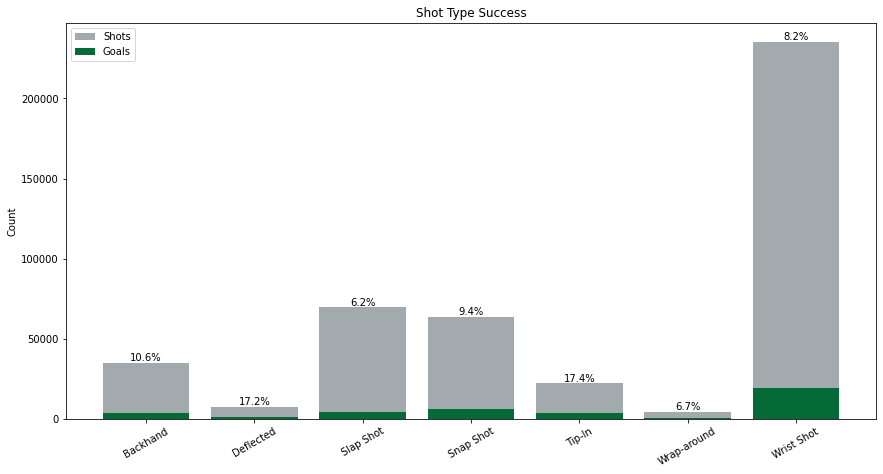

In [10]:
# get goal counts for each type of shot
df_tmp = df[['is_goal', 'shot_type_Backhand', 'shot_type_Deflected', 'shot_type_Slap Shot',
            'shot_type_Snap Shot', 'shot_type_Tip-In', 'shot_type_Wrap-around', 'shot_type_Wrist Shot']].copy() 

# extract data as arrays
x_labels = ['Backhand', 'Deflected', 'Slap Shot', 'Snap Shot', 'Tip-In', 'Wrap-around', 'Wrist Shot']
goals = df_tmp[df_tmp['is_goal']].sum()[1:].values
all_shots = df_tmp.sum()[1:].values

fig = plt.figure()

#### create skater performance plot ###
ax1 = fig.add_subplot()
skater_shots = ax1.bar(x_labels, all_shots,
                color='#A2AAAD',
                label='Shots')
skater_goals = ax1.bar(x_labels, goals,
                color='#046A38',
                label='Goals')
ax1.legend()
plt.title('Shot Type Success')
plt.xlabel("")
plt.ylabel("Count")
plt.xticks(rotation=30)

# print goal percentage for each timezone
rects = ax1.patches # create labels
labels = []
for i in range(len(goals)):
    labels.append(round(goals[i] / all_shots[i] * 100,1))
for rect, label in zip(rects, labels): # apply labels
    height = rect.get_height()
    text_color = 'black'
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, str(label)+'%',
            ha='center', va='bottom', color=text_color)

plt.subplots_adjust(top=1.5, right=2)
plt.show()

Viewing the shot type success rates, it appears that deflections and tip-ins -- although two of the more uncommon shot types -- are the most succesful. Perhaps this is due to random effects. We will expect our models to rely heavily on shot type as a feature. 

### Model Building <a class="anchor" id="5"></a>

In [11]:
# model selection
from sklearn.model_selection import train_test_split, GridSearchCV

# linear models
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV, Lasso, LassoCV
            
# tree based models            
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# other stuff
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer

##### Test Train Split <a class="anchor" id="5.1"></a>
We wish to take a stratified test-train-split of 70% training and 30% testing. Here, strata will be the season each shot came from -- we wish to compose our test/train datasets with similar proportions of shots from each season.

In [12]:
#### delete columns that are unnecessary ####
cols_to_drop = ['game_id', 'home_team', 'away_team',
                'dateTime', 'period', 'periodTime',
                'shooter_team', 'goalie_team', 'strength', 
                'shot_angle_prev', 'shot_dist_prev',
                'shooter_fullName', 'shooter_birthDate', 'shooter_nationality', 'shooter_primaryPosition',
                'goalie_fullName', 'goalie_birthDate', 'goalie_nationality', 
                'goalie_primaryPosition', 'goalie_type']
df = df.drop(cols_to_drop, axis=1)

#### delete rows with weird data ####
df = df[df['shooter_height'].isna() == False] # filter rows where it records a goalie shooting puck


In [13]:
#### book-keeping dataset ####
# in order for our custom scoring metric to work, we need to have a way to re-map
## shot probabilities and shot outcomes back to the original shooters/goalies
df_results = df[['shooter', 'shooter_id', 'goalie', 'goalie_id', 'is_goal']] # use this to score model performance


#### original data ####
# copy dataframe, then drop unecessary cols
df_tmp = df.copy()
df_tmp.drop(['shooter', 'shooter_id', 'goalie', 'goalie_id'], axis=1, inplace=True)

# begin splitting dataset
df_2021FinalModelComparison = df_tmp[df_tmp['season_id'] == '2021'].drop('season_id', axis=1) # final holdout set
df_tmp = df_tmp[df_tmp['season_id'] != '2021']
y = df_tmp.pop('is_goal') # response vector
X = df_tmp.copy()         # predictors
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=123, 
                                                    stratify=X['season_id'])
X_train.drop('season_id', axis=1, inplace=True) # get rid of season_id ... after splitting, we have no use for this
X_test.drop('season_id', axis=1, inplace=True)


#### normalized data ####
# re-copy dataframe and drop unnecessary columns
df_tmp = df.copy()
df_tmp.drop(['shooter', 'shooter_id', 'goalie', 'goalie_id'], axis=1, inplace=True)

# scale all numeric columns
scaler = MinMaxScaler()  # initialize scaler
df_tmp[list(df_tmp.columns)[1:]] = scaler.fit_transform(df_tmp[list(df_tmp.columns)[1:]]) # scale all columns

# begin splitting scaled dataset
df_2021FinalModelComparison_scaled = df_tmp[df_tmp['season_id'] == '2021'].drop('season_id', axis=1) # final holdout set
df_tmp = df_tmp[df_tmp['season_id'] != '2021']
y = df_tmp.pop('is_goal') # response vector
X = df_tmp.copy()         # predictors
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X, 
                                                                                y, 
                                                                                test_size=0.3, 
                                                                                random_state=123,
                                                                                stratify=X['season_id'])
X_train_scaled.drop('season_id', axis=1, inplace=True) # get rid of season_id ... after splitting, we have no use for this
X_test_scaled.drop('season_id', axis=1, inplace=True)

###### Model Training <a class="anchor" id="5.2"></a>

We will train the following models:
* Linear Models
    * Linear Regression
    * Logistic Regression
    * Ridge Regression
    * Lasso Regression
* Tree-Based Models
    * Decision Tree
    * Bagged Tree
    * Random Forest Tree
    * Boosted Tree
    


###### Hyperparameter Tuning
For hyperparameter tuning, we will opt for a custom scoring metric. The scoring function is calculated using the following steps:
* Predict shot probabilities
* Re-map shot probabilities/outcomes back to original shooter_id
* Calculate the sum of shot probabilities for each shooter_id (expected goals)
* Calculate the sum of shot outcomes for each shooter_id (actual goals)
* Calculate the difference between the above two metrics (residual)
* Use these residuals to calculate the RMSE (root-mean-squared error) of this model

Hyperparameters are tuned using 5-fold cross-validation (where appropriate).

In [14]:
def get_rmse(probabilities, shotta, y_test):
    
    # get list of shots tested, add column of shot probability predictions
    df_test = pd.DataFrame(y_test)
    df_test['is_goal_probability'] = probabilities
    df_test.sort_index(inplace=True)

    # join with original dataframe containing skater/goalie names, and shot results
    df_test = df_results[df_results.index.isin(df_test.index)].join(df_test[['is_goal_probability']])

    # get expected goals for each skater
    groups = ['goalie_id', 'goalie']
    if shotta:
        groups = ['shooter_id', 'shooter']
    test_results = df_test.groupby(groups)[['is_goal', 'is_goal_probability']].sum().sort_values('is_goal', ascending=False)
    test_results['error'] = test_results['is_goal_probability'] - test_results['is_goal']
    rmse = np.sqrt(np.mean(np.square(test_results['error'])))
    return rmse

# custom scoring function
def my_custom_loss_func(y_test, y_pred):
    return get_rmse(y_pred, False, y_test)
custom_scorer = make_scorer(my_custom_loss_func, greater_is_better=False)

In [15]:
#### linear regression ####

# initiate model
linreg = LinearRegression()

# fit model
linreg.fit(X_train, y_train)

LinearRegression()

In [16]:
#### logistic regression ####

# initiate model
logit = LogisticRegression(max_iter=200)

# fit model
logit.fit(X_train_scaled, y_train_scaled)

/Users/williamshaw/Projects/NHL/nhl_overtime_eda/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [17]:
#### ridge regression ####

# initiate the cross validation over alphas
r_alphas = np.logspace(0, 5, 50)
ridgereg = RidgeCV(cv=5, 
                   alphas=r_alphas, 
                   scoring=custom_scorer)

# fit the model with the best alpha
ridgereg = ridgereg.fit(X_train_scaled, y_train_scaled)

In [18]:
#### lasso regression ####

# initiate the cross validation over alphas
alphas = np.array([5, 0.5, 0.05, 0.005, 0.0005, 1, 0.1, 0.01, 0.001, 0.0001])
grid = GridSearchCV(estimator=Lasso(), 
                    cv=5,
                    param_grid=dict(alpha=alphas), 
                    scoring=custom_scorer)

# fit the model with the best alpha
lassoreg = grid.fit(X_train_scaled, y_train_scaled)

In [19]:
#### decision tree ####

# use 5-fold cv to get optimal set of hyperparams
param_grid = {"criterion": ['squared_error'],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 4, 8, 16, 32],
              "min_samples_leaf": [20],
              "max_leaf_nodes": [5, 20, 100],
              }
grid_dtm = GridSearchCV(DecisionTreeRegressor(random_state = 123), 
                        cv=5,
                        param_grid=param_grid, 
                        scoring=custom_scorer)

# fit the model
grid_dtm = grid_dtm.fit(X_train, y_train)
dtm = grid_dtm.best_estimator_

In [20]:
#### bagged tree ####

# use 5-fold cv to get optimal set of hyperparams
param_grid = {"n_estimators": [200, 500, 1000],
              "max_features": [1, 2, 3]
              }
grid_bagtm = GridSearchCV(estimator=BaggingRegressor(n_jobs=-1, random_state=123), 
                          cv=5,
                          param_grid=param_grid, 
                          scoring=custom_scorer)

# fit the model
grid_bagtm = grid_bagtm.fit(X_train, y_train)
bagtm = grid_bagtm.best_estimator_

In [21]:
#### random forest tree ####

# use 5-fold cv to get optimal set of hyperparams
param_grid = {"n_estimators": [500, 1000],
              "max_depth": [1, 2, 3]
              }
grid_rftm = GridSearchCV(estimator=RandomForestRegressor(max_features='sqrt', n_jobs=-1, random_state=123), 
                          cv=5,
                          param_grid=param_grid, 
                          scoring=custom_scorer)

# fit the model
grid_rftm = grid_rftm.fit(X_train, y_train)
rftm = grid_rftm.best_estimator_

In [22]:
#### boosted tree ####

# use 5-fold cv to get optimal set of hyperparams
param_grid = {"n_estimators": [500, 1000],
              "max_depth": [1, 2, 3],
              "alpha": [0.01, 0.1]
              }
grid_boosttm = GridSearchCV(estimator=GradientBoostingRegressor(max_features='sqrt', random_state=123), 
                          cv=5,
                          param_grid=param_grid, 
                          scoring=custom_scorer)

# fit the model
grid_boosttm = grid_boosttm.fit(X_train, y_train)
boosttm = grid_boosttm.best_estimator_

##### Model Testing <a class="anchor" id="5.3"></a>

Here, we compare computed error rates of each model. Models have two scores: skater RMSE and goalie RMSE (explanation of calculation in 'Model Training' section). For final model selection, the model with the lowest skater RMSE will be selected.

In [23]:
def get_shooter_rmse(probabilities, y_test):
    return get_rmse(probabilities, True, y_test)

def get_goalie_rmse(probabilities, y_test):
    return get_rmse(probabilities, False, y_test)

def print_rmse(probabilities, y_test):
    print(f'Skaters RMSE: {get_shooter_rmse(probabilities, y_test)}')
    print(f'Goalies RMSE: {get_goalie_rmse(probabilities, y_test)}\n')


In [24]:
#### Linear Regression Testing ####
pred = linreg.predict(X_test)
print('Linear Regression:')
print_rmse(pred, y_test)

#### Logistic Regression Testing ####
probs = logit.predict_proba(X_test_scaled)
pred = pd.DataFrame(probs)[1].values
print('Logistic Regression:')
print_rmse(pred, y_test_scaled)

#### Ridge Regression Testing ####
pred = ridgereg.predict(X_test_scaled)
print(f'Ridge Regression with alpha={round(ridgereg.alpha_, 2)}:')
print_rmse(pred, y_test_scaled)

#### Lasso Regression Testing ####
pred = lassoreg.predict(X_test_scaled)
print(f'Lasso Regression with alpha={lassoreg.best_estimator_.alpha}:')
print_rmse(pred, y_test_scaled)

Linear Regression:
Skaters RMSE: 3.3404497415408754
Goalies RMSE: 9.66564998225205

Logistic Regression:
Skaters RMSE: 3.440217414409009
Goalies RMSE: 9.298403302168316

Ridge Regression with alpha=24420.53:
Skaters RMSE: 3.544107674962134
Goalies RMSE: 8.979135814183389

Lasso Regression with alpha=0.005:
Skaters RMSE: 3.825412151121877
Goalies RMSE: 9.051686274464556



In [25]:
#### Decision Tree Regressor Testing ####
pred = dtm.predict(X_test)
print(f'Decision Tree Regressor')
print_rmse(pred, y_test)

#### Bagged Tree Regressor Testing ####
pred = bagtm.predict(X_test)
print(f'Bagged Tree Regressor')
print_rmse(pred, y_test)

#### Random Forest Tree Regressor Testing ####
pred = rftm.predict(X_test)
print(f'Random Forest Tree Regressor')
print_rmse(pred, y_test)

#### Boosted Tree Regressor Testing ####
pred = boosttm.predict(X_test)
print(f'Boosted Tree Regressor')
print_rmse(pred, y_test)

Decision Tree Regressor
Skaters RMSE: 3.5059416400253496
Goalies RMSE: 9.397066743323078

Bagged Tree Regressor
Skaters RMSE: 4.642575838433614
Goalies RMSE: 8.865604772391494

Random Forest Tree Regressor
Skaters RMSE: 3.6364061855425702
Goalies RMSE: 9.02630882838281

Boosted Tree Regressor
Skaters RMSE: 3.4121183824768226
Goalies RMSE: 9.397216127942032



Given the RMSE scores above, we will select __Random Forest__ as our final model. While this model does not have the best scores across both categories of skaters and goalies for tree based models, it provides a balance between the two.

The model with the best skater RMSE score is linear regression. However, its goalie RMSE score is the worst, therefore, I do not think it is appropriate to select linear regression as our final model. Additionally, I err on picking a linear model to represent this dataset given the information uncovered in the EDA section. For example, [change in shot angle](#4.3) shows a positive impact on succesful shot outcomes up to angle differences of about 100 degrees, and then from there shows a negative impact. I believe the data -- and its intricacies -- can be modeled much more flexibly using a tree based model.

As far as performance for tree based models, bagged trees had the lowest goalie RMSE score and boosted tree had the lowest skaters RMSE score. However, random forest showed scores that were a nice balance of skater and goalies RMSE and therefore, we select random forest as our final model.


### Final Model and Comparison <a class="anchor" id="6"></a>
Finally, we will compare our model performance with an advanced public model from [MoneyPuck](http://moneypuck.com/about.htm#shotModel)!

To do this, we will download their latest predictions for the 2021-22 season and simply calculate the RMSE of the residuals between expectedGoals and actualGoals for each skater. Then we will do the same for our model's prediction on the same data. 

This comparison was performed on all NHL 2021-22 regular season games up to 08Nov2021.

##### Calculate Error Rate of MoneyPuck Model <a class="anchor" id="6.1"></a>

In [26]:
with open('../data/2021moneyPuckExpGoals.csv') as f:
    df_mp = pd.read_csv(f)
    
# extract only expected goals and actual goals
df_mp = df_mp[(df_mp['season'] == 2021) & (df_mp['situation'] == 'all')][['name','I_F_xGoals', 'I_F_goals']]

# group by player and get summed expected goals and actual goals
df_mp = df_mp.groupby('name').sum().sort_values('I_F_xGoals', ascending=False)

# calculate residuals
df_mp['error'] = df_mp['I_F_goals'] - df_mp['I_F_xGoals']

df_mp

,I_F_xGoals,I_F_goals,error
name,,,
John Tavares,7.13,7.0,-0.13
Leon Draisaitl,6.68,10.0,3.32
Alex DeBrincat,6.41,7.0,0.59
Connor McDavid,6.06,8.0,1.94
Chris Kreider,6.05,9.0,2.95
...,...,...,...
Anton Blidh,0.00,0.0,0.00
Kole Lind,0.00,0.0,0.00
Dylan Sikura,0.00,0.0,0.00


In [27]:
rmse_moneypuck = round(np.sqrt(np.mean(np.square(df_mp['error']))), 3)
rmse_moneypuck

1.112

##### Calculate Error Rate of My Model <a class="anchor" id="6.2"></a>
_**Note: my model does not include empty net goals. Therefore, there will be inherent differences in the results/tables/visuals produced comparing the two models_

In [28]:
#### Prepare dataset ####
# there is one game where goalie info was not mined so just delete it (only ~30 shots worth of data)
df_2021FinalModelComparison = df_2021FinalModelComparison[df_2021FinalModelComparison['goalie_height'].isna() == False] 

# separate response from predictors
y_2021 = df_2021FinalModelComparison.pop('is_goal')
X_2021 = df_2021FinalModelComparison.copy()

# get predictions of top rated model
pred = rftm.predict(X_2021)

#### Organize predictions in dataframe ####
# get list of shots tested, add column of shot probability predictions
df_2021 = pd.DataFrame(y_2021)
df_2021['is_goal_probability'] = pred
df_2021.sort_index(inplace=True)

# join with original dataframe containing skater/goalie names, and shot results
df_2021 = df_results[df_results.index.isin(df_2021.index)].join(df_2021[['is_goal_probability']])

# get expected goals for each skater
groups = ['shooter_id', 'shooter']
df_2021 = df_2021.groupby(groups)[['is_goal_probability', 'is_goal']].sum().sort_values('is_goal', ascending=False)
df_2021['error'] = df_2021['is_goal_probability'] - df_2021['is_goal']

df_2021

,,is_goal_probability,is_goal,error
shooter_id,shooter,,,
8471214,Alex Ovechkin,4.721241,9,-4.278759
8475184,Chris Kreider,4.032795,9,-4.967205
8477493,Aleksander Barkov,4.192662,8,-3.807338
8478873,Troy Terry,2.908371,8,-5.091629
8477479,Tyler Bertuzzi,2.954227,8,-5.045773
...,...,...,...,...
8478528,Tanner Kero,0.248535,0,0.248535
8478508,Yakov Trenin,1.534696,0,1.534696
8475906,John Klingberg,0.957899,0,0.957899


In [29]:
# calculate rmse
rmse_davidShaw = np.sqrt(np.mean(np.square(df_2021['error'])))
rmse_davidShaw

1.1963724029445382

The RMSE scores for skater predicted goals vs actual goals for the model built by MoneyPuck is 1.112. In the context of our custom scoring metric, this means that on average, the predictions for the expected number of goals per skater missed by plus/minus 1.112 over games in the 2021-22 season up to 08Nov2021 (~10 games per skater) for all goals (including empty-netters).

Likewise, the RMSE scores for skater predicted goals vs actual goals for the model built in this notebook is 1.196. On average, the predictions for expected number of goals per skater has an error of plus/minus 1.196 for games in the 2021-22 season up to 08Nov2021 not including empty-netters. 

##### Go Beyond Error Rate, Dive into Differences Between Models <a class="anchor" id="6.3"></a>
While the majority of players have only played around 10 games and thus giving us small sample, it is still worth while to explore how these models compare and contrast.

* _Comparison of Error Rate_

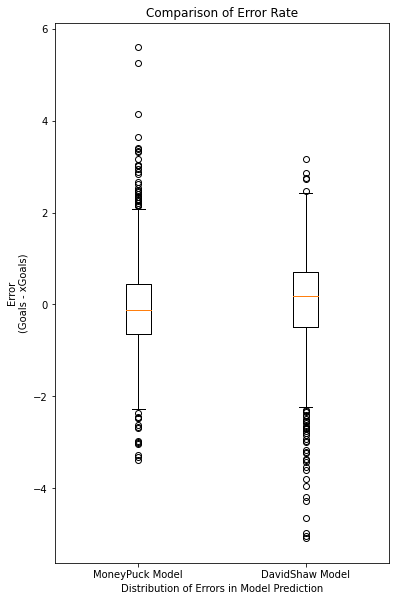

In [30]:
# extract data as array
errors_mp = df_mp['error'].values
errors_ds = df_2021['error'].values

# initialize plots
fig, ax = plt.subplots()
ax.boxplot([errors_mp, errors_ds])

# adjust labels
plt.title('Comparison of Error Rate')
plt.xlabel('Distribution of Errors in Model Prediction')
plt.ylabel('Error\n(Goals - xGoals)')
plt.xticks([1, 2], ['MoneyPuck Model', 'DavidShaw Model'])

plt.subplots_adjust(top=2)
plt.show()

The above chart shows the errors of both models to be grouped around zero. The differences are that MoneyPucks's model underestimates (predicts less goals than actual) whereas my model overestimates (predicts more goals than actual).

* _Comparison of Prediction Ranges_

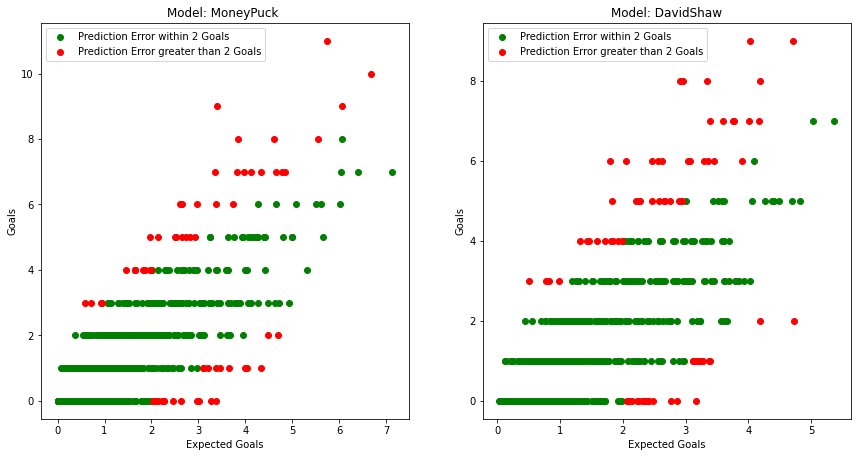

In [31]:
# initialize plots
fig = plt.figure()

# plot1: moneypuck
ax1 = fig.add_subplot(121)
expected_range_mp_lt2 = ax1.scatter(df_mp[np.abs(df_mp['error']) <= 2]['I_F_xGoals'], 
                                    df_mp[np.abs(df_mp['error']) <= 2]['I_F_goals'],
                                    c='green',
                                    label='Prediction Error within 2 Goals'
                                   )
expected_range_mp_gt2 = ax1.scatter(df_mp[np.abs(df_mp['error']) > 2]['I_F_xGoals'], 
                                    df_mp[np.abs(df_mp['error']) > 2]['I_F_goals'],
                                    c='red',
                                    label='Prediction Error greater than 2 Goals'
                                   )
ax1.legend()
plt.title('Model: MoneyPuck ')
plt.xlabel('Expected Goals')
plt.ylabel('Goals')

# plot2: davidshaw
ax2 = fig.add_subplot(122)
expected_range_ds_lt2 = ax2.scatter(df_2021[np.abs(df_2021['error']) <= 2]['is_goal_probability'], 
                                    df_2021[np.abs(df_2021['error']) <= 2]['is_goal'],
                                    c='green',
                                    label='Prediction Error within 2 Goals'
                                   )
expected_range_ds_gt2 = ax2.scatter(df_2021[np.abs(df_2021['error']) > 2]['is_goal_probability'], 
                                    df_2021[np.abs(df_2021['error']) > 2]['is_goal'],
                                    c='red',
                                    label='Prediction Error greater than 2 Goals'
                                   )
ax2.legend()
plt.title('Model: DavidShaw')
plt.xlabel('Expected Goals')
plt.ylabel('Goals')

plt.subplots_adjust(top=1.5, right=2)
plt.show()

As we see above, the two models have very similar distributions of errors. At this point in the season (~10 games), there is not enough data to see clear differences.

### Moving Foward <a class="anchor" id="7"></a>
While xGoals models built on public data have an error just over 1 goal per skater, there is much more variaton to be explained. With the addition of player tracking data, models can improve to capture a larger share of variation by engineering features for events such as screens, accurate change in angle of puck movement (passing and deflections), shot velocity, shot location when a shot reaches the goaltender, etc..   

##### Model Selection: Performance vs Interpretability <a class="anchor" id="7.1"></a>
It should also be mentioned the utility of an xGoals model. When deciding between models, there can be a tradeoff between selecting a model with higher performance vs a model that is interpretable. In the use-case of scouting, is it advantageous to select a model that is marginal in accuracy but hard to understand the importance of its features (ex. logistic regression or ensemble trees)? Should we opt for a less accurate but easier to understand model (ex. linear regression, decision tree)? I prefer the latter; it is my view that data is less reliable in junior/college leagues and, therefore, understanding the features that increase xGoals at least give us the opportunity to manually search for these features in prospects. 

##### Model Selection: Scoring Metrics <a class="anchor" id="7.2"></a>
For hyperparameter tuning and final model selection, we created a custom scoring metric that aggregated all shot predictions by shooter/goalie and compared the sum of those predictions to the actual number of goals scored/allowed by that player. While this is an intuitive scoring metric, I believe that true error rates are higher than the metric implies. For instance when [calculating error rate of my model on 2021-22 games](#6.2), the top scorers had errors in the 3-5 goal range. The worst scorers had low errors, many times below 1. Given there are many more 'low scorers' than 'top scorers', the error rates of the top scorers get averaged out by the low scorers. I believe this may be a problem since the model does not accurately reflect its performance on the skaters we care normally care about when calculating expected goals -- the top goal scorers _(i.e. we wouldn't necessarily care too much about a player like Jordan Martinook's expected goals because we don't expect him to score goals...that is not his role)_.

Therefore, I think a discussion about scoring metrics for an expected goals model is warranted. Other attempts filter model building to players that have a threshold of shot attempts or minutes of icetime. However, I think the problem is much more complex and perhaps could involve multiple RMSE values for 'groups' of players. For instance, calculating RMSE for the top 50 goal scorers, then for the next top 50 goal scorers, and so on. This would provide a more elaborate picture of where each model is missing and allow us to tune models to categories of players we care about more.

##### Model Building: Other Models to Consider  <a class="anchor" id="7.3"></a>
As I mentioned in [model testing](#5.3) section, it is my thinking that linear models are not the most appropriate for this data. I do believe other models would be worth consideration:

* K Nearest-Neighbors
    * a kNN regressor could provide intuitive fit for this type of data given that x and y coordinates are an important factor in the expected goals calculation. Perhaps with more in-depth location data that can provide more features (i.e. location of other players on the ice), kNN would be a strong fit. 
    * another advantage of using kNN is its potential for interpretability
* Naive Bayes
    * this classifier is lightweight and interpretable
* Stacking
    * a form of ensemble learning that combines multiple strong learners' predictions using weights
    * not lightweight and not easily interpretable, but shows promise in improving prediction error

As a final thought, at this point, no matter how many models we decide to train, I believe feature engineering will provide the most efficient gains. There are many characteristics of NHL shots yet to be featurized that can capture a larger portion of variance and output more accurate expected goals predictions.